In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.distributions import NegativeBinomialOutput

from pytorch_lightning.loggers import CSVLogger

from estimator import TFTEstimator

In [4]:
dataset = get_dataset("exchange_rate")

In [6]:
estimator = TFTEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],

    
        scaling=True,
        batch_size=256,
        num_batches_per_epoch=200,
        #distr_output=ImplicitQuantileNetworkOutput("positive"),
        #loss=QuantileLoss(),
        trainer_kwargs=dict(gpus="1", max_epochs=30, logger=CSVLogger(".", "lightning_logs/")),
    )

In [7]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

Epoch 0, global step 200: 'train_loss' reached -2.59856 (best -2.59856), saving model to './lightning_logs/version_41/checkpoints/epoch=0-step=200.ckpt' as top 1
Epoch 1, global step 400: 'train_loss' reached -3.79581 (best -3.79581), saving model to './lightning_logs/version_41/checkpoints/epoch=1-step=400.ckpt' as top 1
Epoch 2, global step 600: 'train_loss' reached -4.05098 (best -4.05098), saving model to './lightning_logs/version_41/checkpoints/epoch=2-step=600.ckpt' as top 1
Epoch 3, global step 800: 'train_loss' reached -4.17670 (best -4.17670), saving model to './lightning_logs/version_41/checkpoints/epoch=3-step=800.ckpt' as top 1
Epoch 4, global step 1000: 'train_loss' reached -4.23045 (best -4.23045), saving model to './lightning_logs/version_41/checkpoints/epoch=4-step=1000.ckpt' as top 1
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Dete

In [10]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [11]:
forecasts = list(forecast_it)

In [12]:
tss = list(ts_it)

In [13]:
evaluator = Evaluator()

In [14]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))


Running evaluation: 40it [00:00, 133.81it/s]


In [15]:
agg_metrics

{'MSE': 0.0007768019271196635,
 'abs_error': 24.153231034986675,
 'abs_target_sum': 975.9766580164433,
 'abs_target_mean': 0.8133138816803693,
 'seasonal_error': 0.006515919403041842,
 'MASE': 4.859690570378005,
 'MAPE': 0.026359366600712142,
 'sMAPE': 0.025865982671578726,
 'MSIS': 28.667572757335584,
 'QuantileLoss[0.1]': 13.229250066354872,
 'Coverage[0.1]': 0.5941666666666666,
 'QuantileLoss[0.2]': 19.524527779966593,
 'Coverage[0.2]': 0.7708333333333334,
 'QuantileLoss[0.3]': 22.889725703932342,
 'Coverage[0.3]': 0.8866666666666667,
 'QuantileLoss[0.4]': 24.396077957376836,
 'Coverage[0.4]': 0.9458333333333334,
 'QuantileLoss[0.5]': 24.153230977244675,
 'Coverage[0.5]': 0.9733333333333334,
 'QuantileLoss[0.6]': 22.207836651802065,
 'Coverage[0.6]': 0.9850000000000001,
 'QuantileLoss[0.7]': 19.237755538709465,
 'Coverage[0.7]': 0.9891666666666665,
 'QuantileLoss[0.8]': 14.866606407612558,
 'Coverage[0.8]': 0.9975000000000002,
 'QuantileLoss[0.9]': 8.850234366022049,
 'Coverage[0.9]

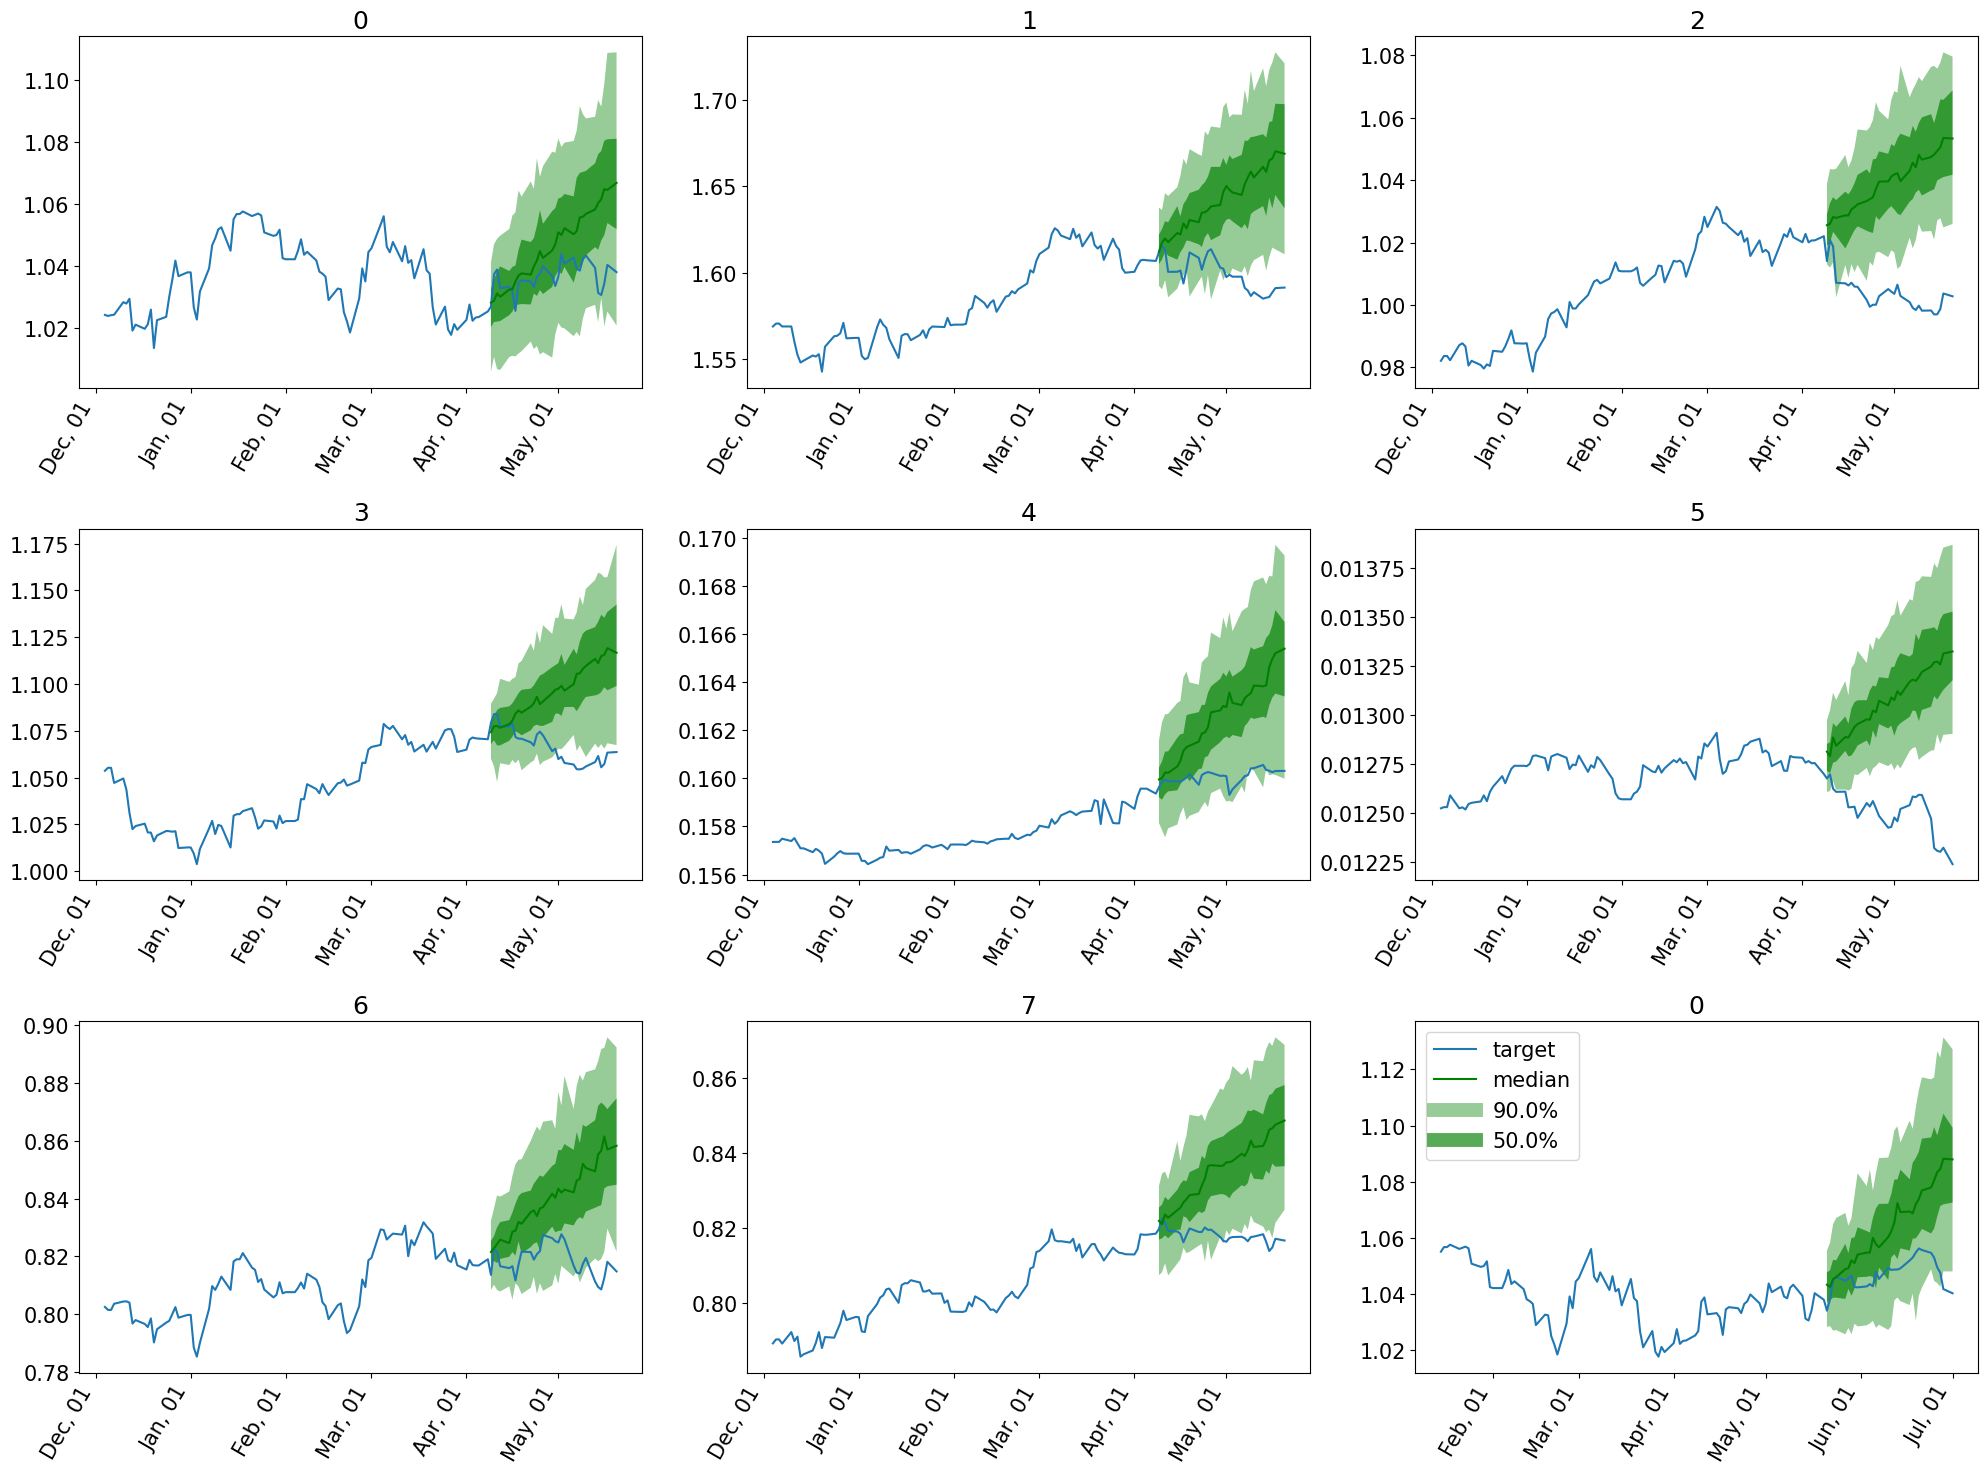

In [16]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [36]:
metrics = pd.read_csv("lightning_logs/version_34/metrics.csv")

In [37]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,1.077298,0,49,NaN,NaN
1,1.052201,0,99,NaN,NaN
2,NaN,0,99,-3.059156,NaN
3,NaN,0,99,NaN,-1.421714
4,1.064031,1,149,NaN,NaN
...,...,...,...,...,...
395,NaN,98,9899,NaN,-4.208968
396,27.830784,99,9949,NaN,NaN
397,26.394091,99,9999,NaN,NaN
398,NaN,99,9999,-4.432779,NaN


Text(0, 0.5, 'perplexity')

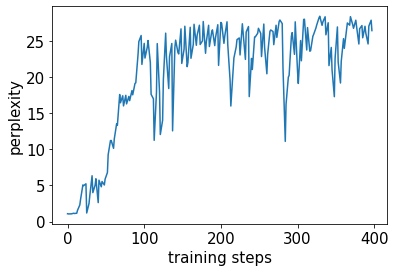

In [38]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

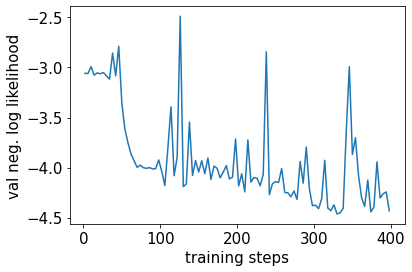

In [39]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [16]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [17]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

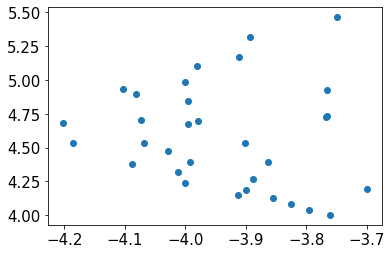

In [18]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)